## ResNet Classification Mini-Project
### Kaggle - Intel Image Classification
- 배경 사진 분류 문제(https://www.kaggle.com/puneet6060/intel-image-classification)
    - 구분 : buildings, forest, glacier, mountain, sea, street  

In [1]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import os
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import ResNet50

In [3]:
tf.__version__

'2.4.0'

In [4]:
# 기존 ResNet50 Layer 구조 확인
ori_res = ResNet50()
ori_res.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [5]:
def conv2_block(x): 
    x = layers.MaxPool2D(pool_size=(3,3),strides=(2,2))(x
    shortcut = x x 

    for i in range(3): # 2bock 3회 반복
        if i==0 :
            x = layers.Conv2D(64, kernel_size=(1,1), strides=(1,1), padding='valid')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)

            x = layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)

            x = layers.Conv2D(256, kernel_size=(1,1), strides=(1,1), padding='valid')(x)
            shortcut = layers.Conv2D(256, kernel_size=(1,1), strides=(1,1), padding='valid')(shortcut) 
            x = layers.BatchNo ~ 뒷부분에서의 복잡한 특성
            shortcut = layers.BatchNormaliza+ x ~ 뒷부분에서의 복잡한 특성
            x = layers.Add()([x,shortcut])
            x = layers.Activation('relu')(x)

            shor # 2회, 3회 시에는 shortcut에 대한 특성 추출 및 batch_normalization 실행 안 함tch_normalization 실행 안 함
            x = layers.Conv2D(64, kernel_size=(1,1), strides=(1,1), padding='valid')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)

            x = layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)

            x = layers.Conv2D(256, kernel_size=(1,1), strides=(1,1), padding='valid')(x)
            x = layers.BatchNormalization()(x) 
            x = layers.Add()([x,shortcut])
            x = layers.Activation('relu')(x)

            shortcut = x
    return x

In [6]:
def conv3_block(x):
    shortcut = x 

    for i in range(4):
        if i==0 :
            x = layers.Conv2D(128, kernel_size=(1,1), strides=(2,2), padding='valid'기 반으로
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)

            x = layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)

            x = layers.Conv2D(512, kernel_size=(1,1), strides=(1,1), padding='valid')(x)
            shortcut = layers.Conv2D(512, kernel_size=(1,1), strides=(2,2), padding='valid')(shortcut) # shortcut 역시 이미지 반으로 
            x = layers.BatchNormalization()(x) # x ~ 뒷부분에서의 복잡한 특성
            shortcut = layers.BatchNormalization()(shortcut)

            # shortcut : 입력단의 단순한 특성 + x ~ 뒷부분에서의 복잡한 특성
            x = layers.Add()([x,shortcut])
            x = layers.Activation('relu')(x)

            shortcut = x
        else : # 2회, 3회 시에는 shortcut에 대한 특성 추출 및 batch_normalization 실행 안 함
            x = layers.Conv2D(128, kernel_size=(1,1), strides=(1,1), padding='valid')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)

            x = layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)

            x = layers.Conv2D(512, kernel_size=(1,1), strides=(1,1), padding='valid')(x)
            x = layers.BatchNormalization()(x) # x ~ 뒷부분에서의 복잡한 특성

            # 2회, 3회 시에는 shortcut에 대한 특성 추출 및 batch_normalization 실행 안 함
            #shortcut = layers.Conv2D(256, kernel_size=(1,1), strides=(1,1), padding='valid')(shortcut) 
            #shortcut = layers.BatchNormalization(shortcut)

            # shortcut : 입력단의 단순한 특성 + x ~ 뒷부분에서의 복잡한 특성
            x = layers.Add()([x,shortcut])
            x = layers.Activation('relu')(x)

            shortcut = x
    return x

In [7]:
def conv4_block(x):
    shortcut = x 

    for i in range(4): # 4block은 6회 / 이었는데 왜 4번만 했지? 반복
        if i==0 :
            x = layers.Conv2D(256, kernel_size=(1,1), strides=(2,2), padding='valid')(x) # 이미지 크기 반으로
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)

            x = layers.Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)

            x = layers.Conv2D(1024, kernel_size=(1,1), strides=(1,1), padding='valid')(x)
            shortcut = layers.Conv2D(1024, kernel_size=(1,1), strides=(2,2), padding='valid')(shortcut) # shortcut 역시 이미지 반으로 
            x = layers.BatchNormalization()(x) # x ~ 뒷부분에서의 복잡한 특성
            shortcut = layers.BatchNormalization()(shortcut)

            # shortcut : 입력단의 단순한 특성 + x ~ 뒷부분에서의 복잡한 특성
            x = layers.Add()([x,shortcut])
            x = layers.Activation('relu')(x)

            shortcut = x
        else : # 2회, 3회 시에는 shortcut에 대한 특성 추출 및 batch_normalization 실행 안 함
            x = layers.Conv2D(256, kernel_size=(1,1), strides=(1,1), padding='valid')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)

            x = layers.Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)

            x = layers.Conv2D(1024, kernel_size=(1,1), strides=(1,1), padding='valid')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Add()([x,shortcut])
            x = layers.Activation('relu')(x)

            shortcut = x
    return x

In [8]:
def conv5_block(x):
    shortcut = x 

    for i in range(3): # 5block은 3회 반복
        if i==0 :
            x = layers.Conv2D(512, kernel_size=(1,1), strides=(2,2), padding='valid')(x) # 이미지 크기 반으로
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)

            x = layers.Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)

            x = layers.Conv2D(2048, kernel_size=(1,1), strides=(1,1), padding='valid')(x)
            shortcut = layers.Conv2D(2048, kernel_size=(1,1), strides=(2,2), padding='valid')(shortcut) # shortcut 역시 이미지 반으로 
            x = layers.BatchNormalization()(x) # x ~ 뒷부분에서의 복잡한 특성
            shortcut = layers.BatchNormalization()(shortcut)

            # shortcut : 입력단의 단순한 특성 + x ~ 뒷부분에서의 복잡한 특성
            x = layers.Add()([x,shortcut])
            x = layers.Activation('relu')(x)

            shortcut = x
        else : # 2회, 3회 시에는 shortcut에 대한 특성 추출 및 batch_normalization 실행 안 함
            x = layers.Conv2D(512, kernel_size=(1,1), strides=(1,1), padding='valid')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)

            x = layers.Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)

            x = layers.Conv2D(2048, kernel_size=(1,1), strides=(1,1), padding='valid')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Add()([x,shortcut])
            x = layers.Activation('relu')(x)

            shortcut = x
    return x

In [9]:
# 함수형 api 코드
image_input = Input(shape=(150,150,3)) # input_layer / 150x150xRGB
# conv1_layer
x = layers.ZeroPadding2D(padding=(1,1))(image_input) # conv1_pad : zero padding # 1->3으로 변경?, image size 156 156 3 확인
x = layers.Conv2D(filters=64,kernel_size=(7,7),strides=(2,2))(x) # conv1_conv : 7x7 kernel, 64 fileter, stride=2
x = layers.BatchNormalization()(x) # conv1_bn
x = layers.Activation('relu')(x) # conv1_relu
x = layers.ZeroPadding2D(padding=(1,1))(x)

x = conv2_block(x) 
x = conv3_block(x)
x = conv4_block(x)
x = conv5_block(x)

x = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(6, activation='softmax')(x)

res_test_model = Model(image_input,output)
res_test_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 152, 152, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 73, 73, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 73, 73, 64)   256         conv2d[0][0]                     
______________________________________________________________________________________________

In [10]:
# 데이터셋 불러오기
train_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.3)
train_generator = train_datagen.flow_from_directory('/content/gdrive/MyDrive/vgg_practice_set/seg_train/seg_train', # 파일 위치 확인
                                                    target_size=(150,150), color_mode='rgb',
                                                    batch_size = 64, shuffle=True, seed = 2020,
                                                    class_mode='categorical', subset='training')

valid_generator = train_datagen.flow_from_directory('/content/gdrive/MyDrive/vgg_practice_set/seg_train/seg_train', # 파일 위치 확인
                                                    target_size=(150,150), color_mode='rgb',
                                                    batch_size = 64, shuffle=True, seed = 2020,
                                                    class_mode='categorical', subset = 'validation')

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory('/content/gdrive/MyDrive/vgg_practice_set/seg_test/seg_test', # 파일 위치 확인
                                                  target_size=(150,150), color_mode='rgb',
                                                  batch_size=1, shuffle=False, seed = 2020,
                                                  class_mode=None) # test set setting check

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

Found 9826 images belonging to 6 classes.
Found 4208 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [11]:
# callback 및 compile 설정
checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/vgg_practice_set/modelcheckpoint/res_best_model.hdf5',
                             verbose = 1, monitor = 'val_accuracy', save_best_only = True) # verbose, monitor option check

res_test_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), # 0.001 // 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
history = res_test_model.fit_generator(generator = train_generator,
                              epochs = 30,
                              steps_per_epoch = STEP_SIZE_TRAIN, # train_generator.n // train_generator.batch_size
                              validation_data=valid_generator,
                              callbacks = [checkpoint],
                              validation_steps = STEP_SIZE_VALID # valid_generator.n // valid_generator.batch_size
                              )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
153/153 [==============================] - 3092s 20s/step - loss: 1.8870 - accuracy: 0.4940 - val_loss: 3.6558 - val_accuracy: 0.1661

Epoch 00001: val_accuracy improved from -inf to 0.16611, saving model to /content/gdrive/MyDrive/vgg_practice_set/modelcheckpoint/res_best_model.hdf5
Epoch 2/30
153/153 [==============================] - 72s 468ms/step - loss: 0.7108 - accuracy: 0.7408 - val_loss: 2.4813 - val_accuracy: 0.3214

Epoch 00002: val_accuracy improved from 0.16611 to 0.32139, saving model to /content/gdrive/MyDrive/vgg_practice_set/modelcheckpoint/res_best_model.hdf5
Epoch 3/30
153/153 [==============================] - 73s 474ms/step - loss: 0.5844 - accuracy: 0.7844 - val_loss: 1.6088 - val_accuracy: 0.5471

Epoch 00003: val_accuracy improved from 0.32139 to 0.54712, saving model to /content/gdrive/MyDrive/vgg_practice_set/modelcheckpoint/res_best_model.hdf5
Epoch 4/30
153/153 [==============================] - 73s 476ms/step - loss: 0.6191 - accuracy: 0.7862 - v

Text(0.5, 1.0, 'loss')

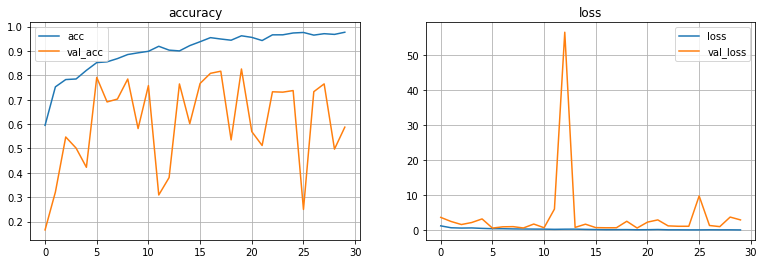

In [13]:
# Accuracy/validation plots
h = history.history
fig = plt.figure(figsize = (13, 4))

plt.subplot(121)
plt.plot(h['accuracy'], label = 'acc')
plt.plot(h['val_accuracy'], label = 'val_acc')
plt.legend()
plt.grid()
plt.title(f'accuracy')

plt.subplot(122)
plt.plot(h['loss'], label = 'loss')
plt.plot(h['val_loss'], label = 'val_loss')
plt.legend()
plt.grid()
plt.title(f'loss')

In [14]:
# Loading weights from best model
res_test_model.load_weights('/content/gdrive/MyDrive/vgg_practice_set/modelcheckpoint/res_best_model.hdf5')

# Saving all model
res_test_model.save('/content/gdrive/MyDrive/vgg_practice_set/modelcheckpoint/res_test_model_save.hdf5')

# Evaluate mmodel
evaluated = res_test_model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)
print(f'Best model loss: {round(evaluated[0], 2)}')
print(f'Best model accuracy: {round(evaluated[1] * 100, 2)}%')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Best model loss: 0.61
Best model accuracy: 82.57%


In [17]:
# Predict classes in test dataset
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size
test_generator.reset()
preds = res_test_model.predict_generator(test_generator, steps = STEP_SIZE_TEST, verbose = 1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3000/3000 [==============================] - 784s 261ms/step


In [18]:
# Creating y_true and y_pred for confusion matrix
predicted_class_indices = np.argmax(preds, axis = 1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
y_pred = [labels[k] for k in predicted_class_indices]
y_true = [labels[k] for k in test_generator.labels]

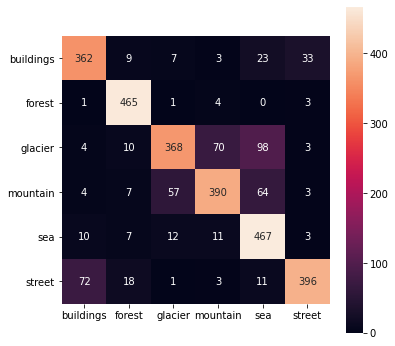

In [19]:
# Plotting confusion matrix
l = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
confusion = confusion_matrix(y_true, y_pred)
fig = plt.figure(figsize = (6, 6))
sns.heatmap(confusion, annot = True, fmt = 'd', xticklabels = l, yticklabels = l, square = True)

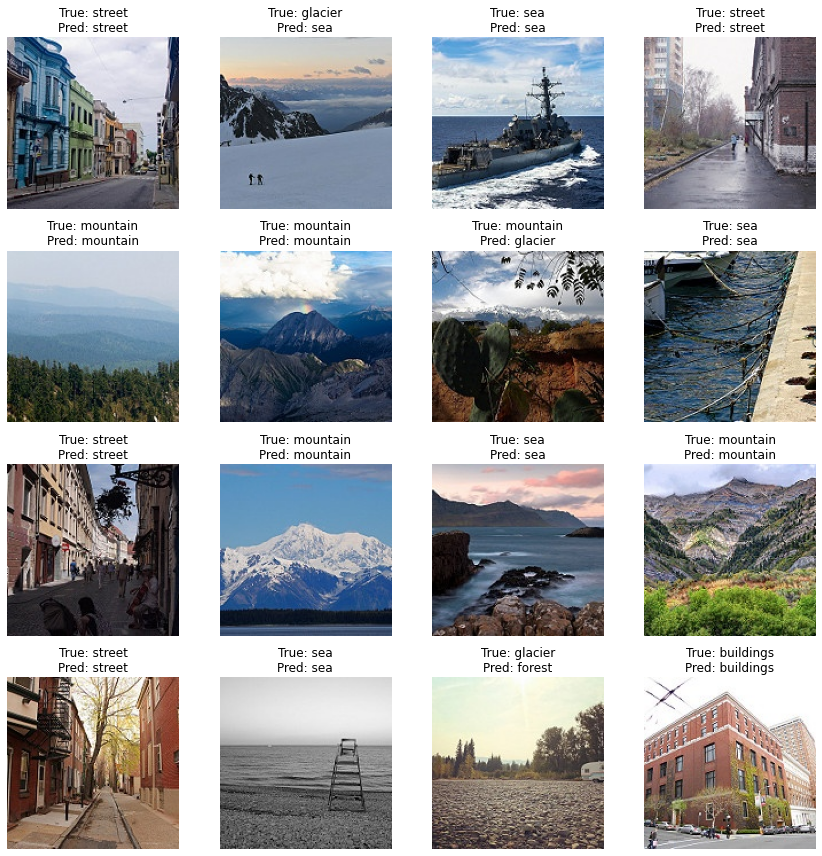

In [20]:
# Showing examples of images with true and predicted classes
filenames = test_generator.filenames
rows, cols = (4, 4)

fig = plt.figure(figsize = (12, 12))
for i in range(rows * cols):
    r = np.random.randint(0, 2999)
    image_path = '/content/gdrive/MyDrive/vgg_practice_set/seg_test/seg_test' + '/' + filenames[r]
    image = cv.imread(image_path)
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(image[:, :, ::-1])
    plt.title(f'True: {filenames[r].split("/")[0]}\nPred: {y_pred[r]}')
    plt.axis('off')

plt.tight_layout()